##  Логистическая регрессия

   В машинном обучении задачей классификации называется ситуация, когда в качестве целевой переменнной $y$ (переменной которую мы хотим предсказать) выступает категориальная переменная. Это означает, что данная переменная задает разбиение нашего датасета на классы, которых может быть как 2, так и больше. 
   
   Нашей задачей в таком случае становится построение алгоритма $a(x)$, который бы смог отделить классы друг от друга в пространстве признаков, или что тоже самое провести разделяющую поверхность между классами.

Начнем с задачи бинарной классификации.

В линейном бинарном классификаторе разделяющая поверхность - гиперплоскость, а алгоритм $a(x)$ задается равенством

$$a(x) = sign(w_0 + \sum_{j = 1}^{d}w_jx^j)$$

где 
$w_0$ - свободный коэффициент
$w_1,...,w_d$ - веса
$x^j$ - признаки

Прежде чем обучать алгоритм, нам необходимо выбрать функционал качества $Q(a, X)$ для нашей задачи.

$$Q(a, X) = \frac{1}{n}\sum_{i=1}^{n}L(y_i, a(x_i))$$

где $L(y, a(x))$ - функция потерь

Как известно, выбрав функционалом качества долю неправильных ответов, мы не сможем решать задачу минимизации с помощью градиентных методов. Поэтому мы аппроксимируем функционал качества сверху $$Q(a, X)\le \frac{1}{n} \sum_{i=1}^{n}\tilde L(y_i, a(x_i))$$

где $\tilde L(y_i, a(x_i))$ гладкая  и диффиренцируемая функция

Одним из решений является логистическая функция потерь, которая имеет следующий вид:

$$
\tilde L(y_i, a(x_i)) = - (y_i \log(p_i) + (1 - y_i) \log(1 - p_i))
$$

где $p_i$ - это вероятность принадлежности объекта $x_i$ к классу 1, предсказанная нашим алгоритмом. 

Чтобы получить $p_i$ введем алгоритм линейной регрессии $b(x)$
$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Чтобы получить алгоритм, который возвращает значения из интервала $(0, 1)$, можно обернуть выход алгоритма $b(x)$ в сигмоиду. Сигмоида это любая S - образная функция принимающая значения из $(0, 1)$. Частный случай: логистическая функция, которая имеет следующий вид:

$$
\sigma (z) = \frac{1}{1 + e^{-z}}
$$




В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как:

$$
p_i = P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

## 1. Обработка данных

#### 1.1 Загрузка данных

Загрузим датасет о пассажирах титаника.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploder = files.upload()

Saving titanic.csv to titanic.csv


In [ ]:
Data = pd.read_csv('titanic.csv')

в файле train.csv каждая строчка наборов данных содержит следующие поля:

- `Survived` - целевая переменная, выжил пассажир или нет

- `Pclass` — класс пассажира (1 — высший, 2 — средний, 3 — низший);

- `Name` — имя;

- `Sex` — пол;

- `Age` — возраст;

- `SibSp` — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;

- `Parch` — количество родителей, детей (в том числе приемных) на борту титаника;

- `Ticket` — номер билета;

- `Fare`— плата за проезд;

- `Cabin` — каюта;

- `Embarked` — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон).
 

In [ ]:
Data.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

Выберем данные, которые будем использовать дальше

In [ ]:
X = Data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
Y = Data['Survived']

#### 1.2 Пропуски в данных

Посмотрим на прогпуски в данных

In [ ]:
X.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Пропуски есть в признаках `Age` и `Embarked`.

`Age` вещественный признак. Заполним пропуски в признаке `Age` средним значением.

Признак `Embarked` категориальный. Заполним пропуск в признаке `Embarked` новым значениемем. 

In [ ]:
X.Age.fillna(X.Age.mean(), inplace = True)

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [ ]:
X.Embarked.fillna('None',  inplace = True)

Посмотрим на получившиеся данные

In [ ]:
X.head()

Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  22.0      1      0   7.2500        S
1       1  female  38.0      1      0  71.2833        C
2       3  female  26.0      0      0   7.9250        S
3       1  female  35.0      1      0  53.1000        S
4       3    male  35.0      0      0   8.0500        S

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.8+ KB


#### 1.3 Обработка категориальных признаков

Чтобы далее мы смогли использовать алгоритм машинного обучения, необходимо все признаки привести к числовому виду.

В данных есть категориальные признаки Sex и Embarked со строковыми значениями.

`Sex` - бинарный признак, заменим ``male`` на 1, а `female` на 0

In [ ]:
X.Sex.unique()

array(['male', 'female'], dtype=object)

In [ ]:
X.loc[:, 'Sex'] = X['Sex'].map({'male': 1, 'female':0})

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


`Embarked` - категориальный признак который содержит 4 уникальных значения.

Чтобы привести его к числовому виду воспользуемся `one-hot` кодировкой

In [ ]:
X.Embarked.unique()

array(['S', 'C', 'Q', 'None'], dtype=object)

In [ ]:
X = pd.get_dummies(X, columns=['Embarked'])

In [ ]:
X['Sex']

0      1
1      0
2      0
3      0
4      1
5      1
6      1
7      1
8      0
9      0
10     0
11     0
12     1
13     1
14     0
15     0
16     1
17     1
18     0
19     0
20     1
21     1
22     0
23     1
24     0
25     0
26     1
27     1
28     0
29     1
      ..
861    1
862    0
863    0
864    1
865    0
866    0
867    1
868    1
869    1
870    1
871    0
872    1
873    1
874    0
875    0
876    1
877    1
878    1
879    0
880    0
881    1
882    0
883    1
884    1
885    0
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int64

#### 1.4 Разделение данных на обучение и контроль

Разделим данные на обучающие и тестовые, чтобы в тестовых оказалось 30% объектов, а в обучающих 70%

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [ ]:
print (X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

((623, 10), (268, 10), (623,), (268,))


#### 1.5 Масштабирование данных

Для линейных методов матрицу объекты-признаки необходимо предварительно масштабировать
(то есть привести каждый признак к одному и тому же масштабу).

Для этого можно воспользоваться StandardScaler или сделать это вручную.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


## 2. LogisticRegression

Будем обучать самый простой бинарный классификатор — логистическую регрессию. 

Используем готовую реализацию LogisticRegression из scikit-learn.

In [ ]:
from sklearn.linear_model import LogisticRegression

Обучим логистическую регрессию на данных X_train.

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. 

Это и есть результат обучения логистической регрессии. 


Посмотрим на то, какие признаки оказались наиболее важными с точки зрения обученной модели. Для этого визуализируем веса, соответствующие признакам. Если признаки отмасштабированы, то чем больше вес по модулю - тем более сильным является признак.

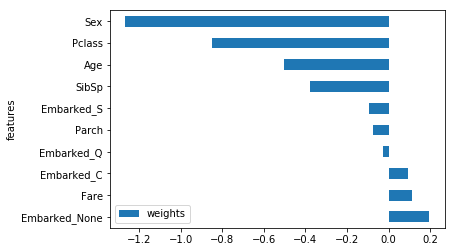

In [ ]:

sorted_weights = sorted(zip(clf.coef_.ravel(), X.columns), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
df = pd.DataFrame({'features': features, 'weights':weights})
ax = df.plot.barh(x='features', y='weights', rot=0, )

Посчитаем с помощью аттрибутов `coef_` и `intercept_` (с помощью всё той же обученной ранее логистической регрессии)  предсказание вероятности принадлежности объекта к положительному классу для тестовой части.

Для этого применим логистическую функцию к  $ w_0 + <w, x>$

Реализуем логистическую функцию и построим её график.

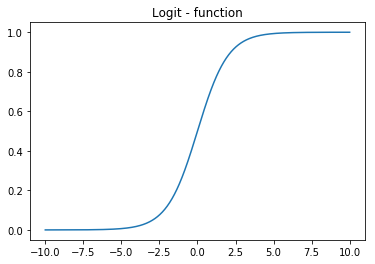

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(-10, 10, 1000)

def logistic_function(x):
    return 1 / (1 + np.exp(-x))

plt.title('Logit - function')
plt.plot(x, logistic_function(x))
plt.show()

предсказание вероятности принадлежности объекта к положительному классу для тестовой части вычислим с помощью матричного произведения в numpy

In [ ]:
pred_prob = np.ravel(logistic_function(np.dot(X_test, clf.coef_.T) + clf.intercept_))

Вычислить предсказание вероятности принадлежности объекта к положительному классу можно и с помощью метода predict_proba

In [ ]:
pred_predict_proba = clf.predict_proba(X_test)[:, 1]

Убедимся, что предсказанные значения совпадают

In [ ]:
np.all([pred_prob, pred_predict_proba])

True

Чтобы получить в качестве предсказания метки классов, можно предсказанные вероятности принадлежности объекта к положительному классу бинаризовать по порогу (например по порогу 0.5)

Бинаризуем по порогу 0.5 и посчитаем долю правильных ответов (accuracy) на тестовой выборке.

In [ ]:
np.mean((pred_prob > 0.5) == Y_test)

0.7947761194029851

Для предсказания меток классов в sklearn есть метод predict.

In [ ]:
pred = clf.predict(X_test)
np.mean(pred == Y_test)

0.7947761194029851

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$.

Применение — подсчёт вероятностей принадлежности положительному классу как применение логистической функции к скалярному произведению признаков и параметров.

Посмотрим на распределение целевого значения

(array([157.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 111.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

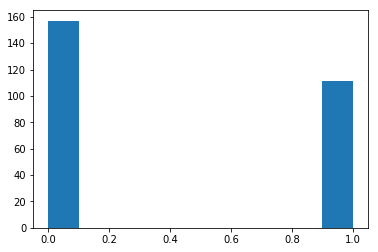

In [ ]:
plt.hist(Y_test)

Посмотрим на распределение предсказываемого значения

(array([54., 58., 24., 22., 12., 10., 20., 16., 25., 27.]),
 array([0.00618686, 0.10189578, 0.19760469, 0.2933136 , 0.38902252,
        0.48473143, 0.58044035, 0.67614926, 0.77185817, 0.86756709,
        0.963276  ]),
 <a list of 10 Patch objects>)

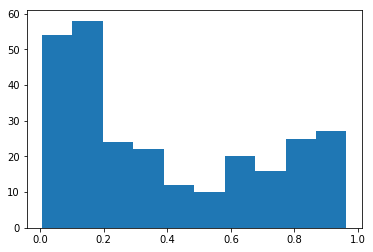

In [ ]:
plt.hist(clf.predict_proba(X_test)[:, 1])

Логистическая регрессия возращает вероятности. Проверим это. Для этого рассмотрим объекты, для которых логистическая регрессия предсказала вероятность принадлежности классу 1 от 0.75 до 0.85. Оценим точность предсказания на этих объектах. При большом числе объектов в выборке точность предсказания должна быть близка к 0.8.

In [ ]:
predict_proba = clf.predict_proba(X_test)[:, 1]

In [ ]:
np.mean(Y_test[(predict_proba > 0.75) & (predict_proba < 0.85)])

0.84